In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from tqdm import tqdm
import torchmetrics
from collections import Counter
from sklearn.metrics import classification_report
import torchvision.datasets as datasets
from sklearn.metrics import classification_report


In [3]:
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [5]:
transform = transforms.Compose([
    #torchvision.transforms.Grayscale(num_output_channels=3),
    transforms.Resize((256, 256)), # Resize all images to a uniform size (e.g., 64x64 pixels)
    transforms.ToTensor(), # Convert PIL Image to PyTorch tensor (0-255 to 0.0-1.0)
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize pixel values
])

In [6]:


train_data_dir = 'dataset/Human Faces Dataset' 
full_dataset = torchvision.datasets.ImageFolder(root=train_data_dir, transform=transform)
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [0.7, 0.3])



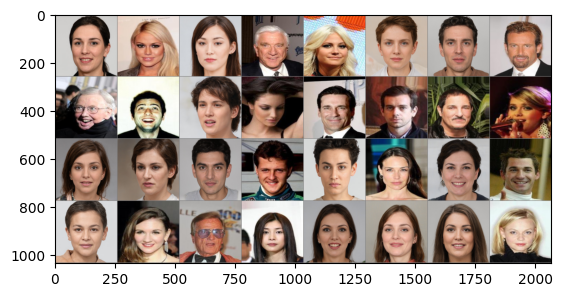

In [7]:
batch_size = 32
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True, # Shuffle data for training
    num_workers=2 # Use multiple subprocesses for data loading 
)

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

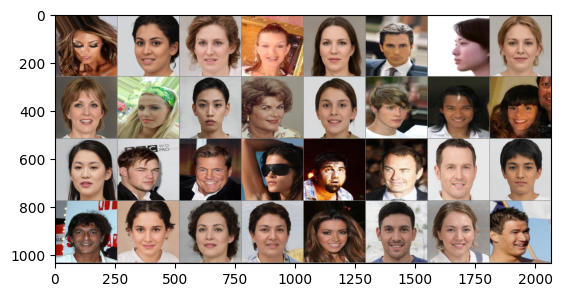

In [8]:

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True, # Shuffle data for training
    num_workers=2 # Use multiple subprocesses for data loading 
)

# get some random training images
dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92941177..0.94509804].


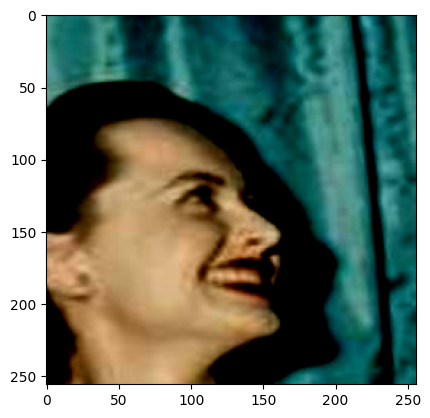

torch.Size([3, 256, 256])

In [9]:
#Sanity check (set shuffle=False in loader so order in file explorer is perserved)
index=0
npimg=train_loader.dataset[index][0].numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()
train_loader.dataset[index][1]

img, label=train_loader.dataset[index]
img.size()


In [10]:
# Get the targets for the subset
train_targets = [full_dataset.targets[i] for i in train_dataset.indices]

# Calculate the class distribution
train_distribution = Counter(train_targets)
print(f"Train distribution: {train_distribution}")


# Get the targets for the subset
test_targets = [full_dataset.targets[i] for i in test_dataset.indices]

# Calculate the class distribution
test_distribution = Counter(test_targets)
print(f"Test distribution: {test_distribution}")

Train distribution: Counter({0: 3474, 1: 3267})
Test distribution: Counter({0: 1526, 1: 1363})


<h2>ACTUAL CNN </h2>

In [11]:
class CNN(nn.Module):
   def __init__(self, in_channels, num_classes):

       """
       Building blocks of convolutional neural network.

       Parameters:
           * in_channels: Number of channels in the input image (for grayscale images, 1)
           * num_classes: Number of classes to predict. In our problem, 10 (i.e digits from  0 to 9).
       """
       super(CNN, self).__init__()

       # 1st convolutional layer
       self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=3, padding=1)
       # Max pooling layer
       self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
       # 2nd convolutional layer
       self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
       # Fully connected layer
       self.fc1 = nn.Linear(16 * 64 * 64, num_classes)

   def forward(self, x):
       """
       Define the forward pass of the neural network.

       Parameters:
           x: Input tensor.

       Returns:
           torch.Tensor
               The output tensor after passing through the network.
       """
       x = F.relu(self.conv1(x))  # Apply first convolution and ReLU activation
       x = self.pool(x)           # Apply max pooling
       x = F.relu(self.conv2(x))  # Apply second convolution and ReLU activation
       x = self.pool(x)           # Apply max pooling
       x = x.reshape(x.shape[0], -1)  # Flatten the tensor
       x = self.fc1(x)            # Apply fully connected layer
       return F.log_softmax(x, dim=1)
    


In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNN(in_channels=3, num_classes=2).to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
num_epochs=10
for epoch in range(num_epochs):
# Iterate over training batches
  print(f"Epoch [{epoch + 1}/{num_epochs}]")
  running_loss=0.0
  for batch_index, (data, targets) in enumerate(tqdm(train_loader)):
      data = data.to(device)
      targets = targets.to(device)
      scores = model(data)
      loss = criterion(scores, targets)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss+=loss.item()
  print(f"Loss: {running_loss/len(train_loader):.8f}")

Epoch [1/10]


100%|██████████| 211/211 [01:13<00:00,  2.89it/s]


Loss: 0.06087979
Epoch [2/10]


100%|██████████| 211/211 [00:38<00:00,  5.49it/s]


Loss: 0.00105118
Epoch [3/10]


100%|██████████| 211/211 [01:50<00:00,  1.91it/s]


Loss: 0.00019068
Epoch [4/10]


100%|██████████| 211/211 [01:53<00:00,  1.87it/s]


Loss: 0.00006355
Epoch [5/10]


100%|██████████| 211/211 [01:48<00:00,  1.94it/s]


Loss: 0.00003349
Epoch [6/10]


100%|██████████| 211/211 [01:55<00:00,  1.82it/s]


Loss: 0.00002303
Epoch [7/10]


100%|██████████| 211/211 [01:55<00:00,  1.82it/s]


Loss: 0.00001372
Epoch [8/10]


100%|██████████| 211/211 [01:51<00:00,  1.90it/s]


Loss: 0.00000315
Epoch [9/10]


100%|██████████| 211/211 [01:58<00:00,  1.78it/s]


Loss: 0.00000127
Epoch [10/10]


100%|██████████| 211/211 [01:59<00:00,  1.77it/s]

Loss: 0.00000067


In [14]:
# Set up of multiclass accuracy metric
acc = torchmetrics.Accuracy(task="binary")

# Iterate over the dataset batches
acc.reset()
model.eval()
ypreds=[]
ytrues=[]
with torch.no_grad():
   for images, labels in test_loader:
       # Get predicted probabilities for test data batch
       outputs = model(images)
       _, preds = torch.max(outputs, 1)
       acc.update(preds, labels)
       ypreds.extend(preds)
       ytrues.extend(labels)
       #precision(preds, labels)
       #recall(preds, labels)

#Compute total test accuracy
test_accuracy = acc.compute()
print(f"Test accuracy: {test_accuracy}")

Test accuracy: 1.0
